In [1]:
#load package
.libPaths(c("/cluster/home/liuhengxin/software/miniconda3_2/envs/r-kernel/lib/R/library",
           "/cluster/home/liuhengxin/software/miniconda3/envs/r4.1.2/lib/R/library",
           "/cluster/home/liuhengxin/software/miniconda3_2/envs/Rsplot/lib/R/library"))
library(data.table)
library(qs) 
library(GenomicRanges)
library(GenomicFeatures)
library(rtracklayer)
library(dplyr)
library(ggbio)
library(reshape2)
library(ggsci)
library(viridis)
library(ggpubr)
library(ggh4x)
library(ggtranscript)
library(khroma)
library(bambu)
library(ggdensity)
library(Seurat)
library(ggsignif) # Significance Brackets for 'ggplot2'
library(gghalves) # Compose Half-Half Plots Using Your Favourite Geoms
library(randomcoloR)
library(ComplexHeatmap)
library(ggvenn)

qs 0.25.5

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:data.table’:

    first, second


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: I

In [2]:
setwd("/cluster/home/liuhengxin/P1_brain_nanopore/")
MySplit = function(str,sep, n){
  return(unlist(lapply(strsplit(str,sep),"[[",n)))
}

In [11]:
theme_presentation<- function(base_size = 16, base_family = "") {
  # Starts with theme_grey and then modify some parts
  theme_bw(base_size = base_size, base_family = base_family) %+replace%
    theme(
      strip.background = element_blank(),
      strip.text.x = element_text(size=16,colour="white"),
      strip.text.y = element_text(size=16,colour="white"),
      axis.text.x = element_blank(),
      axis.text.y = element_blank(),
      axis.ticks =  element_blank(), 
      axis.title.x= element_blank(),
      axis.title.y= element_blank(),
      panel.background = element_rect(fill="black"), 
      panel.border =element_blank(),  
      panel.grid.major = element_blank(), 
      panel.grid.minor = element_blank(), 
      panel.margin = unit(1.0, "lines"), 
      plot.background = element_rect(fill="black"), 
      plot.title =element_text(size=16,colour="white"), 
      # plot.margin = unit(c(1,  1, 1, 1), "lines"),
      legend.background=element_rect(fill='black'),
      legend.title=element_text(size=12,colour="white"),
      legend.text=element_text(size=12,colour="white"),
      legend.key = element_rect( fill = 'black'),
      # legend.key.size = unit(c(0, 0), "lines"),
      axis.line.x = element_blank(),
      axis.line.y = element_blank()
    )
}

SpCasePlot = function(fsraw.cor,geneex,hubtrans,backpt,ptsize = 1,backsize = 0.05){
    mkdf = fsraw.cor[fsraw.cor$gene_id == geneex,]
    mkdf = mkdf[mkdf$transcript_id %in% hubtrans,]
    mkdf = mkdf[order(as.numeric(factor(mkdf$transcript_id,levels = hubtrans))),]
    mycolor = distinctColorPalette(length(hubtrans))
    #mkdf = mkdf[order(mkdf$transcript_id),]
    pmkpti1 = ggplot() +
      scattermore::geom_scattermore(
        data = backpt,
        aes(x,y),
        color = "white",
        # pixels = raster.dpi,
        pointsize = backsize
      ) +
      geom_point(data = mkdf,
                 aes(x,y,fill = transcript_id),shape = 21,size = ptsize,stroke = NA) + 
      # geom_segment(data = edgesdf, aes(x = x1, y = y1, xend = x2, yend = y2,color = areatr),
      #            size = 0.5,alpha = 0.75) + 
     # scale_size(range = c(0.05,0.1)) +
      #facet_wrap(~layer,nrow = 2) 
      theme_void() +
      scale_fill_discreterainbow() +
      #scale_fill_manual(values = mycolor) +
      #scale_color_flatui() +
      theme_presentation() + 
      theme(legend.position = "top",legend.title = element_blank(),
            legend.text = element_text(size = 18)) +
      guides(color = guide_legend(override.aes = list(size=8),nrow = 3),
            fill = guide_legend(override.aes = list(size=8),nrow = 2),
            size = "none")
      #scale_y_reverse() + scale_x_reverse()
    return(pmkpti1)
}

## Preprocess fullscope data

### Bambu process

In [3]:
#bambu annotation
.libPaths(c("/cluster/home/liuhengxin/software/miniconda3_2/envs/r-kernel/lib/R/library",
           "/cluster/home/liuhengxin/software/miniconda3/envs/r4.1.2/lib/R/library",
           "/cluster/home/liuhengxin/software/miniconda3_2/envs/Rsplot/lib/R/library"))
library(bambu)
library(qs)
OuttablefromBambu = function(readtrans,sample){
    readtransf = readtrans[(lengths(readtrans$compatibleMatches) + lengths(readtrans$equalMatches)) > 0,]
    nrow(readtransf)
    rtnume = lengths(readtransf$equalMatches)
    rtnumc = lengths(readtransf$compatibleMatches)
    readid = rep(readtransf$readId,rtnume)
    tranid = unlist(readtransf$equalMatches)

    readtransf.dfe = data.frame("readid" = readid,
                              "tranid" = tranid,
                               "type" = "equal")
    readid = rep(readtransf$readId,rtnumc)
    tranid = unlist(readtransf$compatibleMatches)

    readtransf.dfc = data.frame("readid" = readid,
                              "tranid" = tranid,
                               "type" = "compatible")
    readtransf.df = rbind(readtransf.dfe,readtransf.dfc)
    readtransf.df = readtransf.df[!duplicated(readtransf.df[,1:3]),]
    readtransf.df$sample = sample
    return(readtransf.df)
}

BambuMatrixBuild = function(bamls,bambuAnnotations,genome,outfile,samples){
    se <- bambu(reads = c(bamls), 
                annotations = bambuAnnotations, 
                genome = genome,discoveries
               trackReads = TRUE)
    se
    qsave(se,file = paste0(outfile,"_se.qs"))
    
    readtransf.df = NULL
    for(i in 1:length(metadata(se)$readToTranscriptMaps)){
        readtransf.dfi = OuttablefromBambu(metadata(se)$readToTranscriptMaps[[i]],samples[i])
        readtransf.df = rbind(readtransf.df,readtransf.dfi)
    }
    print(length(unique(readtransf.df$readid)))
    qsave(readtransf.df,file = paste0(outfile,"_trans_total_anno.qs"))
    return(readtransf.df)
}

setwd("/cluster/home/liuhengxin/P1_brain_nanopore/")
bambuAnnotations <- prepareAnnotations("ref/bambu_extended_annotations_novelname.gtf")
genome = "/cluster/home/liuhengxin/P1_brain_nanopore/ref/GCF_000364345.1_Macaca_fascicularis_5.0_genomic.fa"

#ONT
#bamls = "/cluster/home/liuhengxin/P1_brain_nanopore/processed_data/T47_analysis/ONT/Alignment/T47.bam"
#outfile = "/cluster/home/liuhengxin/P1_brain_nanopore/processed_data/T47_analysis/ONT/T47_bambu_ont"
#samples = c("T47_ont")
#readtrans.ont = BambuMatrixBuild(bamls,bambuAnnotations,genome,outfile,samples)
#length(unique(readtrans.ont$readid))



#bamls = "/cluster/home/liuhengxin/P1_brain_nanopore/processed_data/T47_analysis/Cyclone/Alignment/T47.bam"
#outfile = "/cluster/home/liuhengxin/P1_brain_nanopore/processed_data/T47_analysis/Cyclone/T47_bambu_cyclone"



In [4]:
#pacbio revo
setwd("/cluster/home/liuhengxin/P1_brain_nanopore/")
bambuAnnotations <- prepareAnnotations("ref/bambu_extended_annotations_novelname.gtf")
genome = "/cluster/home/liuhengxin/P1_brain_nanopore/ref/GCF_000364345.1_Macaca_fascicularis_5.0_genomic.fa"
bamls = "/cluster/home/liuhengxin/P1_brain_nanopore/processed_data/T42_analysis/Revo/Alignment/T42_pacbio_251119.sorted.bam"
outfile = "/cluster/home/liuhengxin/P1_brain_nanopore/processed_data/T42_analysis/Revo/T42_bambu_annotations"
samples = c("T42_revo")
readtransf.df = BambuMatrixBuild(bamls,bambuAnnotations,genome,outfile,samples)

Detected Bambu derived annotations in the annotations. Set a new prefix with opt.discovery(list(prefix='newPrefix')) to prevent ambigious id assignment.

--- Start generating read class files ---

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    BioCsoft: https://bioconductor.org/packages/3.18/bioc
    BioCann: https://bioconductor.org/packages/3.18/data/annotation
    BioCexp: https://bioconductor.org/packages/3.18/data/experiment
    BioCworkflows: https://bioconductor.org/packages/3.18/workflows
    BioCbooks: https://bioconductor.org/packages/3.18/books
    CRAN: https://cran.r-project.org



[12:59:14] WARNING: src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[12:59:16] WARNING: src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



Detected 2 warnings across the samples during read class construction. Access warnings with metadata(bambuOutput)$warnings

--- Start extending annotations ---

Warning message:
"There was 1 warning in `summarise()`.
ℹ In argument: `intersectWidth = max(intersectWidth)`.
Caused by warning in `max()`:
! no non-missing arguments to max; returning -Inf"
Warning message:
"Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.
ℹ The deprecated feature was likely used in the bambu package.
  Please report the issue to the authors."
Warning message:
"There was 1 warning in `summarise()`.
ℹ In argument: `intersectWidth = max(intersectWidth)`.
Caused by warning in `max()`:
! no non-missing arguments to max; returning -Inf"
Warning message:
"There was 1 warning in `filter()`.
ℹ In argum

[1] 103092345


In [6]:
se = qread("/cluster/home/liuhengxin/P1_brain_nanopore/processed_data/T42_analysis/Revo/T42_bambu_annotations_se.qs")
se

class: RangedSummarizedExperiment 
dim: 117150 1 
metadata(3): readToTranscriptMaps incompatibleCounts warnings
assays(4): counts CPM fullLengthCounts uniqueCounts
rownames(117150): AAAS-WeiLab-1 AAAS-WeiLab-2 ...
  unstranded.Gene92-WeiLab-1 unstranded.Gene99-WeiLab-1
rowData names(11): TXNAME GENEID ... txid eqClassById
colnames(1): T42_pacbio_251119.sorted
colData names(1): name

In [14]:
sean = as.data.frame(rowData(se))
head(sean)
sean = sean[,c("TXNAME","GENEID","txid")]
colnames(sean) = c("transcript_id","gene_id","txid")
matchid = match(readtransf.df$tranid,sean$txid)
readtransf.df$transcript_id = sean$transcript_id[matchid]
readtransf.df$gene_id = sean$gene_id[matchid]
head(readtransf.df)

,TXNAME,GENEID,NDR,novelGene,novelTranscript,txClassDescription,readCount,relReadCount,relSubsetCount,txid,eqClassById
,<chr>,<chr>,<dbl>,<lgl>,<lgl>,<chr>,<int>,<lgl>,<lgl>,<int>,<list>
AAAS-WeiLab-1,AAAS-WeiLab-1,AAAS,NA,FALSE,FALSE,annotation,NA,NA,NA,1,1
AAAS-WeiLab-2,AAAS-WeiLab-2,AAAS,NA,FALSE,FALSE,annotation,NA,NA,NA,2,2
AADAT-WeiLab-1,AADAT-WeiLab-1,AADAT,NA,FALSE,FALSE,annotation,NA,NA,NA,3,3
AAED1-WeiLab-1,AAED1-WeiLab-1,AAED1,NA,FALSE,FALSE,annotation,NA,NA,NA,4,"4, 5"
AAED1-WeiLab-2,AAED1-WeiLab-2,AAED1,NA,FALSE,FALSE,annotation,NA,NA,NA,5,5
AAMDC-WeiLab-1,AAMDC-WeiLab-1,AAMDC,NA,FALSE,FALSE,annotation,NA,NA,NA,6,6


,readid,tranid,type,sample,transcript_id,gene_id
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
1,read_598779|adapterA_RC-adapterB_RC|6621-7369(-),40295,equal,T42_revo,PGBD2-WeiLab-1,PGBD2
2,read_845256|adapterL-adapterM|475-1307(+),40295,equal,T42_revo,PGBD2-WeiLab-1,PGBD2
3,read_1166915|adapterI|1-842(+),40295,equal,T42_revo,PGBD2-WeiLab-1,PGBD2
4,read_1244932|adapterI|1-818(+),40295,equal,T42_revo,PGBD2-WeiLab-1,PGBD2
5,read_1360746|adapterD_RC-adapterE_RC|4676-5419(-),40295,equal,T42_revo,PGBD2-WeiLab-1,PGBD2
6,read_2032812|adapterC_RC-adapterD_RC|6462-7251(-),40295,equal,T42_revo,PGBD2-WeiLab-1,PGBD2


In [15]:
qsave(readtransf.df,file = paste0(outfile,"_trans_total_anno.qs"))

### NGS annotation build

In [1]:
import pandas as pd
# 读取CSV文件
cellidan = pd.read_csv("/cluster/home/liuhengxin/P1_brain_nanopore/ref/T42/total_cell_annotation_T42_macaque_f001_2D_20220928_type20221110-macaque1-contour2.csv")
celltpan = pd.read_csv("/cluster/home/liuhengxin/P1_brain_nanopore/ref/T47/cell_type_type20230220-macaque1-contour2_v1.csv")
cellidan = pd.merge(cellidan, celltpan, on="cell_type_id")
cellidan = cellidan.iloc[:, 1:7]
areaan = pd.read_csv("/cluster/home/liuhengxin/P1_brain_nanopore/ref/T42/20221110-macaque1-merge.csv")
areaan = areaan[areaan['chip'] == "T42"]
areaan = areaan[['global_region_id', 'origin_name']].drop_duplicates()

In [ ]:
#T47的22版注释细胞类型是正确的，但是region id补全，而2311和2312的region id都是全的，但是细胞类型注释不匹配，故而先根据新版的来修正T47的region，再做细胞类型映射
#ngscount = pd.read_parquet("/cluster/home/liuhengxin/P1_brain_nanopore/ref/T42/total_gene_T42_macaque_f001_2D_20230704-macaque1-total.parquet")
#ngscount['spot'] = ngscount['x'].astype(str) + '_' + ngscount['y'].astype(str)
#ngscount = ngscount[['spot', 'gene_area']].drop_duplicates()
#ngscount.to_csv("/cluster/home/liuhengxin/P1_brain_nanopore/ref/T42/total_gene_T42_macaque_f001_2D_macaque-20230704_spotan.csv", index=False)

ngscount = pd.read_csv("/cluster/home/liuhengxin/P1_brain_nanopore/ref/T42/total_gene_T42_macaque_f001_2D_20221110-merge.txt",sep = "\t")
print(ngscount.head())
ngscount['spot'] = ngscount['x'].astype(str) + '_' + ngscount['y'].astype(str)
# spot_to_genearea = rawngs_new.set_index('spot')['gene_area'].to_dict()
# ngscount['gene_area'] = ngscount['spot'].map(spot_to_genearea)

ngscount = pd.merge(ngscount, cellidan, left_on="cell_label", right_on="cell_id", how="left")
len(ngscount)
ngscount = pd.merge(ngscount, areaan[['global_region_id', 'origin_name']], left_on="gene_area", right_on="global_region_id", how="left")
len(ngscount)
print(ngscount.head())
ngscount.to_parquet("/cluster/home/liuhengxin/P1_brain_nanopore/ref/T42/total_gene_T42_macaque_f001_2D_macaque_withan_25_11_21.parquet")
span = ngscount[['x', 'y','cell_label', 'gene_area','cell_id',
                 'cell_type_id','cell_type','subclass','class','global_region_id','origin_name']].drop_duplicates(keep='first')
span = span.reset_index(drop=True)
span.to_parquet("/cluster/home/liuhengxin/P1_brain_nanopore/ref/T42/total_gene_T42_macaque_f001_2D_macaque_withan_dedup_25_11_21.parquet")
import pandas as pd
#ngscount = pd.read_csv("/cluster/home/liuhengxin/P1_brain_nanopore/ref/T42/total_gene_T42_macaque_f001_2D_macaque_withan_25_11_21.txt",sep = "\t")
span = span[span['origin_name'] != "background"]
span['x'].describe()
def my_split(string, separator, index):
    parts = string.split(separator)
    return parts[index] if index < len(parts) else None
span['layer'] = span['origin_name'].apply(lambda x: my_split(x, '-', 2))
span['region'] = span['origin_name'].apply(lambda x: my_split(x, '-', 1))
groupan_data = {
    "abv": ["cb", "cortex", "HC", "mb", "p", "str", "v", "amy", "HyTh", "cla", "wm", "th", "GP"],
    "ano": ["Cerebellum", "Cortex", "Hippocampus", "Midbrain", 
            "Pons", "Striatum", "Ventricle", "Amygdala", "Hypothalamus",
            "Claustrum", "Whitematter", "Thalamus", "Globuspallidus"]
}
groupan = pd.DataFrame(groupan_data)
span['subcortical'] = span['layer']
cortex_layers = [f"l{i}" for i in range(1, 7)]
span.loc[span['subcortical'].isin(cortex_layers), 'subcortical'] = 'cortex'
span['subcortical'] = span['subcortical'].map(groupan.set_index('abv')['ano'])
span.to_csv("/cluster/home/liuhengxin/P1_brain_nanopore/ref/T42/total_gene_T42_macaque_f001_2D_macaque_withan_dedup_nobackground_25_11_21.txt",sep='\t')

In [4]:
span

,x,y,cell_label,gene_area,cell_id,cell_type_id,cell_type,subclass,class,global_region_id,origin_name,layer,region,subcortical
0,47978,57263,116721.0,812,116721.0,13.0,GLU L2/3.2 CD53/COL5A2,L2/3,GLU,812,L-TAa-l3,l3,TAa,Cortex
3,16655,71720,832852.0,792,NaN,NaN,NaN,NaN,NaN,792,L-SC-mb,mb,SC,Midbrain
4,34985,40275,0.0,583,NaN,NaN,NaN,NaN,NaN,583,L-LIPd-l4,l4,LIPd,Cortex
5,51336,61142,0.0,818,NaN,NaN,NaN,NaN,NaN,818,L-TEO-l3,l3,TEO,Cortex
7,17262,78721,782074.0,524,NaN,NaN,NaN,NaN,NaN,524,L-IC-mb,mb,IC,Midbrain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523461998,48865,62268,0.0,818,NaN,NaN,NaN,NaN,NaN,818,L-TEO-l3,l3,TEO,Cortex
523461999,25162,86273,668551.0,1009,NaN,NaN,NaN,NaN,NaN,1009,L-cb-cb,cb,cb,Cerebellum
523462001,22898,48195,0.0,993,NaN,NaN,NaN,NaN,NaN,993,L-VIP-l3,l3,VIP,Cortex
523462002,50916,58567,0.0,812,NaN,NaN,NaN,NaN,NaN,812,L-TAa-l3,l3,TAa,Cortex


/tmp/ipykernel_40916/2347426542.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


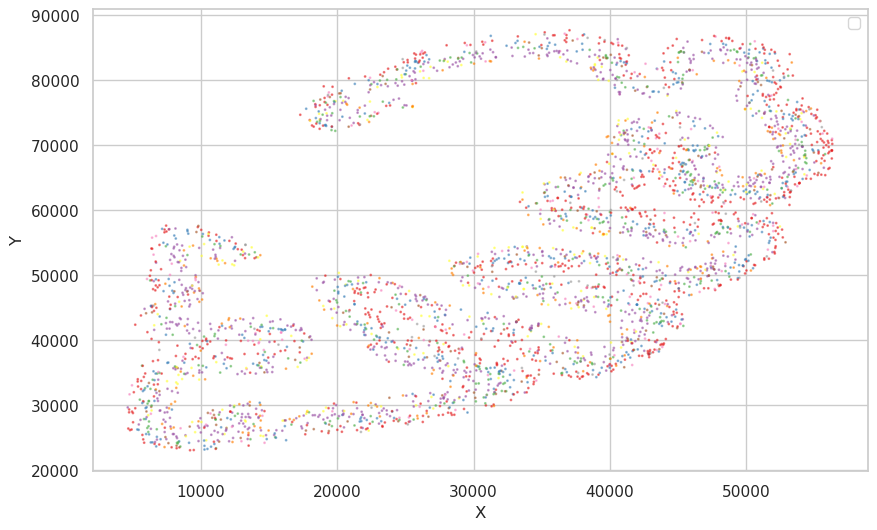

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
fig, ax = plt.subplots(figsize=(10, 6))
# 按 'region' 分组，并从每组中抽取10%的数据
span_down = ngscount.sample(n=10000, random_state=42)
span_down = pd.merge(span_down[['x','y','gene_area','subclass']], areaan[['global_region_id', 'origin_name']], 
                     left_on="gene_area", right_on="global_region_id", how="left")
# len(ngscount)
span_down = span_down[span_down['origin_name'] != "background"]
span_down = span_down[span_down['origin_name'].notna()]
# span_down = pd.merge(span_down, cellidan, left_on="cell_id", right_on="cell_label", how="left")
span_down = span_down[span_down['subclass'].notna()]

subclass = span_down['subclass'].to_list()
subclass = pd.Categorical(subclass).codes + 1
# 绘图代码同上
# ax.scatter(x=span_down['x'], y=span_down['y'],  alpha=0.5, s=1)
ax.scatter(x=span_down['x'], y=span_down['y'],  alpha=0.5, s=1,c=subclass,cmap='Set1')

# 添加标签和图例
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()

# 显示图形
plt.show()

### Efficience calculate

In [18]:
#revo
cidext.rv = read.delim("/cluster/home/liuhengxin/P1_brain_nanopore/processed_data/T42_analysis/Revo/CIDextract/T42_pacbio_cidextract_251119.tsv",header = FALSE)
cidmap.rv = read.delim("/cluster/home/liuhengxin/P1_brain_nanopore/processed_data/T42_analysis/Revo/CIDmapping/T42_pacbio_cidmap_251119.tsv",header = TRUE)
colnames(cidext.rv) = c("readid","strand","pos","type","cidseq")
length(unique(cidext.rv$readid))
length(unique(cidmap.rv$readid))
summary(cidmap.rv$editDi)

[1] 157927572

[1] 117033920

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.1581  0.0000  1.0000 

### Merge all annotation

In [19]:
span = fread("/cluster/home/liuhengxin/P1_brain_nanopore/ref/T42/total_gene_T42_macaque_f001_2D_macaque_withan_dedup_nobackground_25_11_21.txt")

In [20]:
#load cid map and transcript anno for pacbio
library(data.table)
#nrow(readtransf.df)
readtransf.df = merge(readtransf.df,cidmap.rv[,c("readid","cidPos")])
#nrow(readtransf.df)
qsave(readtransf.df,"/cluster/home/liuhengxin/P1_brain_nanopore/processed_data/T42_analysis/Revo/T42_trans_total_anno_withcid_25_11_21.qs")
#head(readtransf.df)
span$cidPos = paste0(span$x,"_",span$y) 
readtransf.df = merge(readtransf.df,span,by = "cidPos")
head(readtransf.df)

,cidPos,readid,tranid,type,sample,transcript_id,gene_id,V1,x,y,⋯,cell_id,cell_type_id,cell_type,subclass,class,global_region_id,origin_name,layer,region,subcortical
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
1,10000_22740,read_1179842|adapterI_RC|5173-6092(-),34232,compatible,T42_revo,LOC102116757-WeiLab-1,LOC102116757,248997023,10000,22740,⋯,NA,NA,,,,288,L-3a/b-l1,l1,3a/b,Cortex
2,10000_22740,read_9836492|adapterI_RC|5173-6092(-),34232,compatible,T42_revo,LOC102116757-WeiLab-1,LOC102116757,248997023,10000,22740,⋯,NA,NA,,,,288,L-3a/b-l1,l1,3a/b,Cortex
3,10000_22740,read_1179842|adapterI_RC|5173-6092(-),34233,compatible,T42_revo,LOC102116757-WeiLab-2,LOC102116757,248997023,10000,22740,⋯,NA,NA,,,,288,L-3a/b-l1,l1,3a/b,Cortex
4,10000_22740,read_9836492|adapterI_RC|5173-6092(-),34233,compatible,T42_revo,LOC102116757-WeiLab-2,LOC102116757,248997023,10000,22740,⋯,NA,NA,,,,288,L-3a/b-l1,l1,3a/b,Cortex
5,10000_22740,read_9836492|adapterI_RC|5173-6092(-),72966,compatible,T42_revo,XM_005592569.2,LOC102116757,248997023,10000,22740,⋯,NA,NA,,,,288,L-3a/b-l1,l1,3a/b,Cortex
6,10000_22740,read_1179842|adapterI_RC|5173-6092(-),72966,compatible,T42_revo,XM_005592569.2,LOC102116757,248997023,10000,22740,⋯,NA,NA,,,,288,L-3a/b-l1,l1,3a/b,Cortex


ERROR: Error in qsave(readtransf.df, "/cluster/home/liuhengxin/P1_brain_nanopore/processed_data/T47_analysis/Revo/T42_trans_total_anno_withcid_an_25_11_21.qs"): Failed to open file for writing. 
- Does the directory exist?
 - Do you have file permissions?
- Is the file name long? (usually 255 chars)


In [21]:
qsave(readtransf.df,"/cluster/home/liuhengxin/P1_brain_nanopore/processed_data/T42_analysis/Revo/T42_trans_total_anno_withcid_an_25_11_21.qs")

In [22]:
nrow(readtransf.df)

[1] 78658747

### Build Fsraw and transmx dtu

In [4]:
gtfdfant.kn = read.csv("downstream_analysis/ref/gtf_filter_final_with_newname_25_10_09.csv")
readtransf.df = qread("/cluster/home/liuhengxin/P1_brain_nanopore/processed_data/T42_analysis/Revo/T42_trans_total_anno_withcid_an_25_11_21.qs")
head(readtransf.df)
head(gtfdfant.kn)

,cidPos,readid,tranid,type,sample,transcript_id,gene_id,V1,x,y,⋯,cell_id,cell_type_id,cell_type,subclass,class,global_region_id,origin_name,layer,region,subcortical
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
1,10000_22740,read_1179842|adapterI_RC|5173-6092(-),34232,compatible,T42_revo,LOC102116757-WeiLab-1,LOC102116757,248997023,10000,22740,⋯,NA,NA,,,,288,L-3a/b-l1,l1,3a/b,Cortex
2,10000_22740,read_9836492|adapterI_RC|5173-6092(-),34232,compatible,T42_revo,LOC102116757-WeiLab-1,LOC102116757,248997023,10000,22740,⋯,NA,NA,,,,288,L-3a/b-l1,l1,3a/b,Cortex
3,10000_22740,read_1179842|adapterI_RC|5173-6092(-),34233,compatible,T42_revo,LOC102116757-WeiLab-2,LOC102116757,248997023,10000,22740,⋯,NA,NA,,,,288,L-3a/b-l1,l1,3a/b,Cortex
4,10000_22740,read_9836492|adapterI_RC|5173-6092(-),34233,compatible,T42_revo,LOC102116757-WeiLab-2,LOC102116757,248997023,10000,22740,⋯,NA,NA,,,,288,L-3a/b-l1,l1,3a/b,Cortex
5,10000_22740,read_9836492|adapterI_RC|5173-6092(-),72966,compatible,T42_revo,XM_005592569.2,LOC102116757,248997023,10000,22740,⋯,NA,NA,,,,288,L-3a/b-l1,l1,3a/b,Cortex
6,10000_22740,read_1179842|adapterI_RC|5173-6092(-),72966,compatible,T42_revo,XM_005592569.2,LOC102116757,248997023,10000,22740,⋯,NA,NA,,,,288,L-3a/b-l1,l1,3a/b,Cortex


,transcript_id,gene_id,trantype,transnew,fulllength,transnew2
,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
1,BambuTx1,PGBD2,novel,PGBD2-WeiLab-1,599,PGBD2-FS-1
2,BambuTx10,ZNF669,novel,ZNF669-WeiLab-1,203,ZNF669-FS-1
3,BambuTx1000,USP21,novel,USP21-WeiLab-2,413,USP21-FS-2
4,BambuTx100007,LOC102142787,novel,LOC102142787-WeiLab-1,105,LOC102142787-FS-1
5,BambuTx100045,EXOC3L4,novel,EXOC3L4-WeiLab-1,72,EXOC3L4-FS-1
6,BambuTx100047,EXOC3L4,novel,EXOC3L4-WeiLab-2,37,EXOC3L4-FS-2


In [ ]:
nrow(fsraw.raw.t42)
nrow(fsraw.t42)
fsraw.raw.t42.equal = readtransf.df[readtransf.df$type == "equal",]
nrow(fsraw.raw.t42.equal)
fsraw.raw.t42.cmp = readtransf.df[readtransf.df$type != "equal",]
nrow(fsraw.raw.t42.cmp)
fsraw.raw.t42.cmp = fsraw.raw.t42.cmp[!fsraw.raw.t42.cmp$readid %in% fsraw.raw.t42.equal$readid,]
nrow(fsraw.raw.t42.cmp)
readtransf.df = rbind(fsraw.raw.t42.cmp,fsraw.raw.t42.equal)

In [5]:
readtransf.df = readtransf.df[readtransf.df$transcript_id %in% gtfdfant.kn$transnew,]
nrow(readtransf.df)
readtransf.df$transcript_id = gtfdfant.kn[match(readtransf.df$transcript_id,gtfdfant.kn$transnew),]$transnew2
head(readtransf.df)

[1] 46307755

,cidPos,readid,tranid,type,sample,transcript_id,gene_id,V1,x,y,⋯,cell_id,cell_type_id,cell_type,subclass,class,global_region_id,origin_name,layer,region,subcortical
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
1,10000_22740,read_1179842|adapterI_RC|5173-6092(-),34232,compatible,T42_revo,LOC102116757-FS-1,LOC102116757,248997023,10000,22740,⋯,NA,NA,,,,288,L-3a/b-l1,l1,3a/b,Cortex
2,10000_22740,read_9836492|adapterI_RC|5173-6092(-),34232,compatible,T42_revo,LOC102116757-FS-1,LOC102116757,248997023,10000,22740,⋯,NA,NA,,,,288,L-3a/b-l1,l1,3a/b,Cortex
3,10000_22740,read_1179842|adapterI_RC|5173-6092(-),34233,compatible,T42_revo,LOC102116757-FS-2,LOC102116757,248997023,10000,22740,⋯,NA,NA,,,,288,L-3a/b-l1,l1,3a/b,Cortex
4,10000_22740,read_9836492|adapterI_RC|5173-6092(-),34233,compatible,T42_revo,LOC102116757-FS-2,LOC102116757,248997023,10000,22740,⋯,NA,NA,,,,288,L-3a/b-l1,l1,3a/b,Cortex
5,10000_22740,read_9836492|adapterI_RC|5173-6092(-),72966,compatible,T42_revo,XM_005592569.2,LOC102116757,248997023,10000,22740,⋯,NA,NA,,,,288,L-3a/b-l1,l1,3a/b,Cortex
6,10000_22740,read_1179842|adapterI_RC|5173-6092(-),72966,compatible,T42_revo,XM_005592569.2,LOC102116757,248997023,10000,22740,⋯,NA,NA,,,,288,L-3a/b-l1,l1,3a/b,Cortex


In [6]:
length(unique(readtransf.df$readid))

[1] 24380860

In [7]:
fsraw.cor = readtransf.df %>% group_by(readid) %>% filter(length(unique(transcript_id)) == 1)
length(unique(fsraw.cor$readid))
qsave(fsraw.cor,"downstream_analysis/data/reads_full_anotation/T42_main_data_read_total_annotation_delete_multiread_total_25_12_01.qs")

[1] 14968338

In [59]:
span = fread("/cluster/home/liuhengxin/P1_brain_nanopore/ref/T42/total_gene_T42_macaque_f001_2D_macaque_withan_dedup_nobackground_25_11_21.txt")
head(span)

V1,x,y,cell_label,gene_area,cell_id,cell_type_id,cell_type,subclass,class,global_region_id,origin_name,layer,region,subcortical
<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
0,47978,57263,116721,812,116721,13,GLU L2/3.2 CD53/COL5A2,L2/3,GLU,812,L-TAa-l3,l3,TAa,Cortex
3,16655,71720,832852,792,NA,NA,,,,792,L-SC-mb,mb,SC,Midbrain
4,34985,40275,0,583,NA,NA,,,,583,L-LIPd-l4,l4,LIPd,Cortex
5,51336,61142,0,818,NA,NA,,,,818,L-TEO-l3,l3,TEO,Cortex
7,17262,78721,782074,524,NA,NA,,,,524,L-IC-mb,mb,IC,Midbrain
8,40821,46720,804323,325,804323,38,GLU L2/3/4.2 WDR86/USH1C,L2/3/4,GLU,325,L-7op-l3,l3,7op,Cortex


In [ ]:
playerno = ggplot() +
    geom_point(
      data = span[span$subcortical == "Cortex",],
      aes(x, y, color = layer),
      size= 0.1
    ) +
    scale_color_discreterainbow() +
    guides(color = guide_legend(override.aes = list(size=3),
                                title = "Brain regions")) +
    theme_presentation() + scale_x_reverse()  + scale_y_reverse()
playerno
#ggexport(playerno,filename = "downstream_analysis/result/figure_revision/T47_annotation_brain_region_25_07_20.pdf",width = 7,height = 6)

Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."


In [14]:
#calculate DTUs
transtls = list()

#build data
{
    FullLengthTranSt = function(fs.info){
      transtl = fs.info %>% group_by(gene_id, areatr) %>% 
        mutate(genecount = length(unique(readid))) %>% 
        group_by(gene_id,transcript_id,areatr) %>% 
        summarise(count = length(unique(readid)),
                  genecount = unique(genecount))
      transtl = transtl[transtl$areatr != "" &
                          !is.na(transtl$areatr),]
      return(transtl)
    }
    
    #layer
    # npclf = npclf[npclf$arealayer %in% paste0("l",1:6),]
    fs.info.cortex = fsraw.cor[fsraw.cor$subcortical %in% paste0("Cortex"),]
    fs.info.cortex$areatr = fs.info.cortex$layer
    transtls$layer = FullLengthTranSt(fs.info.cortex)
    
    # #region
    fs.info.cortex$areatr = fs.info.cortex$region
    transtls$region = FullLengthTranSt(fs.info.cortex)
    
    # #lobe
    # fs.info.cortex$areatr = fs.info.cortex$lobe
    # transtls$lobe = FullLengthTranSt(fs.info.cortex)
    
    #subclass
    fs.info.cortex$areatr = fs.info.cortex$subclass
    transtls$subclass = FullLengthTranSt(fs.info.cortex)
    
    #class
    fs.info.cortex$areatr = fs.info.cortex$class
    transtls$class = FullLengthTranSt(fs.info.cortex)
    
    # #class
    # fsraw.cor$areatr = fsraw.cor$subcortical
    # transtls$subcortical = FullLengthTranSt(fsraw.cor)
    
}
qsave(transtls,"downstream_analysis/data/reads_full_anotation/T42_read_trans_stat_list_dedup_fsrawcor_25_12_01.qs")

`summarise()` has grouped output by 'gene_id', 'transcript_id'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'gene_id', 'transcript_id'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'gene_id', 'transcript_id'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'gene_id', 'transcript_id'. You can
override using the `.groups` argument.


In [15]:
transt = transtls$layer
CalSigIsoform = function(transt){
    transt = transt[!is.na(transt$areatr),]
    transt = transt[transt$areatr != "",]
    transt$relative = transt$count/transt$genecount
    #transtf = transt[transt$count > 5,]
    transtf = transt[transt$genecount > 20,]
    transtf = transtf %>% group_by(transcript_id) %>% 
      mutate(meanrelative = mean(relative),
             otherrelative = (sum(relative) - relative)/(n() - 1))
    transtf = transtf[which(transtf$meanrelative > 0.05),]

    arean = length(unique(transtf$areatr))

    #areanth = arean*(1/3)
   # print(areanth)
    transtf = transtf %>% group_by(transcript_id) %>% 
       filter(length(unique(areatr)) > 1)
    transtf = transtf %>% group_by(gene_id) %>% 
      filter(length(unique(transcript_id))>1)
    
    # transtf$lfc = log2(transtf$relative/transtf$meanrelative)
    transtf$dr = transtf$relative - transtf$otherrelative
    transtf$sig = "N"
    table(transtf$sig)
    
    #transtf$pvalue = 1
    MyChiqTest = function(transcript_id, areatr, count){
      dat = data.frame(transcript_id = transcript_id, areatr = areatr,
                       count = count)
      dat = dcast(dat, areatr~transcript_id,
                  value.var = "count",
                  fun.aggregate = sum)
      rownames(dat) = dat$areatr;dat = dat[-1]
      p = tryCatch(chisq.test(as.matrix(dat))$p.value, 
                   error = function(e) NA)
      return(p)
    }
    pvdf = transtf %>% group_by(gene_id) %>% summarise(pvalue = MyChiqTest(transcript_id, areatr, count))
    pvdf$padj = p.adjust(pvdf$pvalue,method = "BH")
    transtf = merge(transtf,pvdf,by = "gene_id")
    #print(head(transtf))
    # table(transtf[transtf$padj < 0.05,]$sig)
    #transtf[transtf$padj < 0.05,]$sig = "Y"
    transtf[which(transtf$dr > 0.1 & transtf$padj < 0.05 & transtf$count > 10), "sig"] = "Up"
    transtf[which(transtf$dr < -0.1 & transtf$padj < 0.05 & transtf$count > 10), "sig"] = "Down"
    return(transtf)
}
  isosigls = list()
for (i in 1:length(transtls)) {
    print(i)
    isosigls[[i]] = CalSigIsoform(transtls[[i]])
}
names(isosigls) = names(transtls)
for (i in 1:length(isosigls)) {
    print(length(unique(isosigls[[i]][isosigls[[i]]$sig!="N",]$gene_id)))
}
qsave(isosigls,file = "downstream_analysis/data/dtu_analysis/T42_dtu_isoform_ls_fsraw_cor_25_12_01.qs")

[1] 1


Warning message:
"There were 1133 warnings in `summarise()`.
The first warning was:
ℹ In argument: `pvalue = MyChiqTest(transcript_id, areatr, count)`.
ℹ In group 4: `gene_id = "ABAT"`.
Caused by warning in `chisq.test()`:
! Chi-squared approximation may be incorrect
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1132 remaining warnings."


[1] 2


Warning message:
"There were 1091 warnings in `summarise()`.
The first warning was:
ℹ In argument: `pvalue = MyChiqTest(transcript_id, areatr, count)`.
ℹ In group 2: `gene_id = "AARSD1"`.
Caused by warning in `chisq.test()`:
! Chi-squared approximation may be incorrect
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1090 remaining warnings."


[1] 3


Warning message:
"There were 795 warnings in `summarise()`.
The first warning was:
ℹ In argument: `pvalue = MyChiqTest(transcript_id, areatr, count)`.
ℹ In group 1: `gene_id = "AARSD1"`.
Caused by warning in `chisq.test()`:
! Chi-squared approximation may be incorrect
ℹ Run `dplyr::last_dplyr_warnings()` to see the 794 remaining warnings."


[1] 4


Warning message:
"There were 495 warnings in `summarise()`.
The first warning was:
ℹ In argument: `pvalue = MyChiqTest(transcript_id, areatr, count)`.
ℹ In group 1: `gene_id = "ABAT"`.
Caused by warning in `chisq.test()`:
! Chi-squared approximation may be incorrect
ℹ Run `dplyr::last_dplyr_warnings()` to see the 494 remaining warnings."


[1] 471
[1] 703
[1] 439
[1] 162


In [44]:
#isosigi = isosigls$class
#isosigi[isosigi$count > 200 & abs(isosigi$dr) > 0.15,]
#isosigi = isosigls$region
nrow(readtransf.df[readtransf.df$gene_id == "ARPP19",])

[1] 71174

In [17]:
backpt = unique(fsraw.cor[,c("x","y","layer","region","subcortical")])
qsave(backpt,file = "downstream_analysis/data/dtu_analysis/T42_longread_cell_isoform_without_subcortical_25_11_24.qs")

Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
file saved to downstream_analysis/result/figure_revision/T42_DDRGK1_layer_case_bin1_25_11_24.pdf



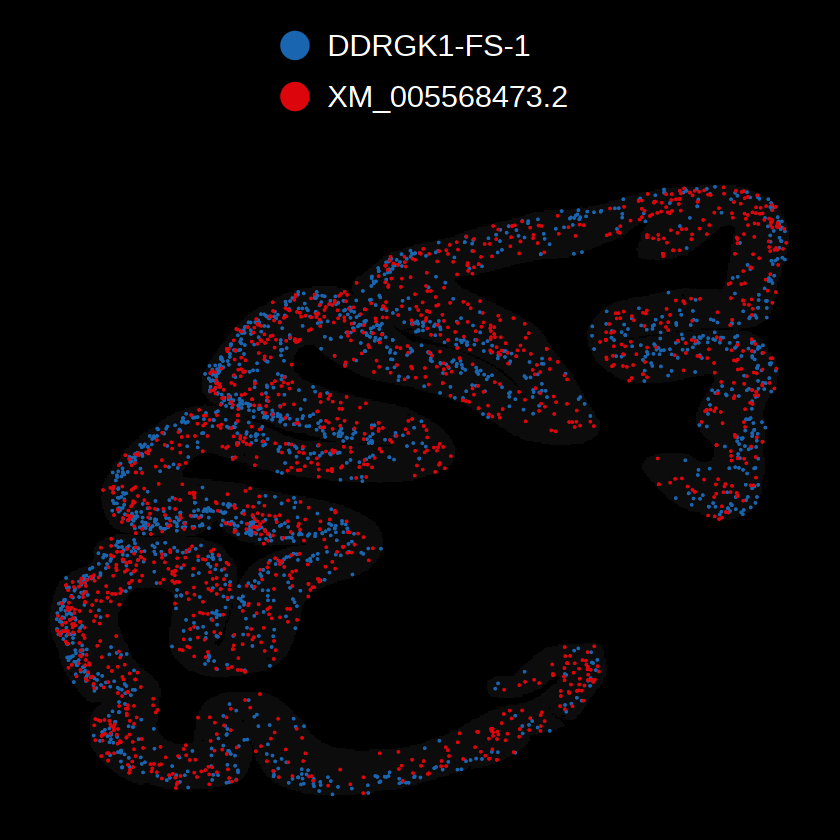

In [55]:
geneex = "DDRGK1"
transid = c("DDRGK1-FS-1","XM_005568473.2")
# fsraw.hub = readtransf.df[readtransf.df$layer %in% paste0("l",1:6) & readtransf.df$gene_id %in% geneex,]
# fsraw.hub = fsraw.hub %>% group_by(readid) %>% filter(transcript_id == "DDRGK1-FS-1" | sum(transcript_id %in% "DDRGK1-FS-1") == 0)
pc1 = SpCasePlot(fs.info.cortex,geneex,transid,backpt[backpt$layer %in% paste0("l",1:6),],0.7)
pc1 = pc1 + scale_x_reverse() + scale_y_reverse()
pc1
fileid = paste0("downstream_analysis/result/figure_revision/T42_",geneex,"_layer_case_bin1_25_11_24.pdf")
ggexport(pc1,filename = fileid,width = 4,height = 6)

Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
file saved to downstream_analysis/result/figure2/T42_DBNDD2_layer_case_bin1_25_11_24.pdf



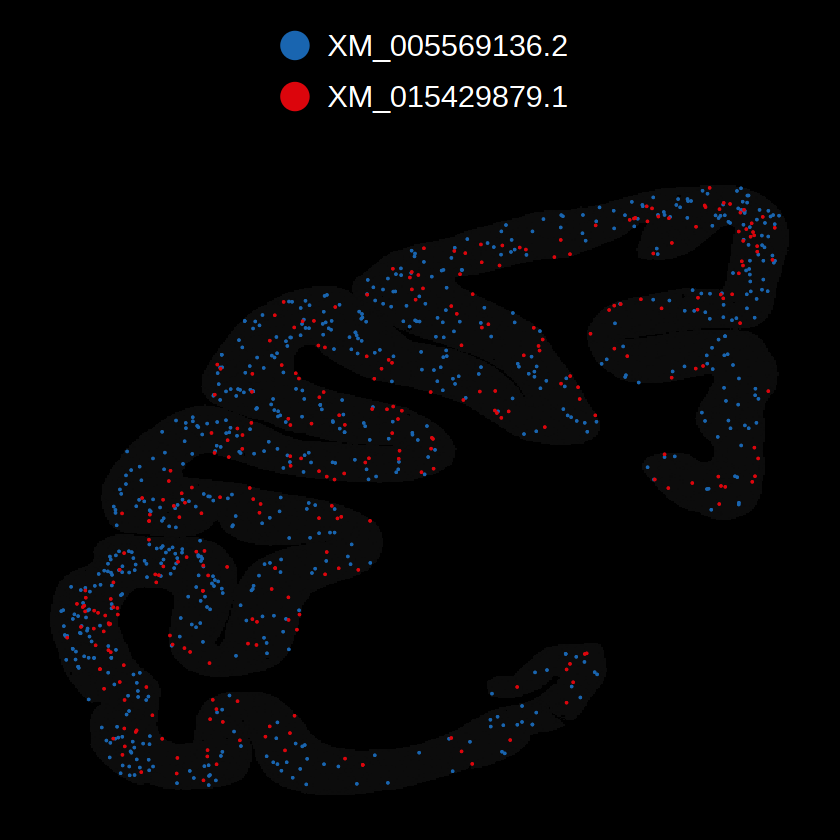

In [58]:
geneex = "DBNDD2"
transid = c("XM_005569136.2","XM_015429879.1")
#edgesdf.zoom = edgesdf[edgesdf$areaid %in% "PEa",]
pc2 = SpCasePlot(fs.info.cortex,geneex,transid,backpt[backpt$layer %in% paste0("l",1:6),],0.7)
pc2 = pc2 + scale_x_reverse()  + scale_y_reverse()
pc2
fileid = paste0("downstream_analysis/result/figure2/T42_",geneex,"_layer_case_bin1_25_11_24.pdf")
ggexport(pc2,filename = fileid,width = 4,height = 6)

Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
file saved to downstream_analysis/result/figure_revision/T42_ARPP19_layer_case_bin1_25_11_24.pdf



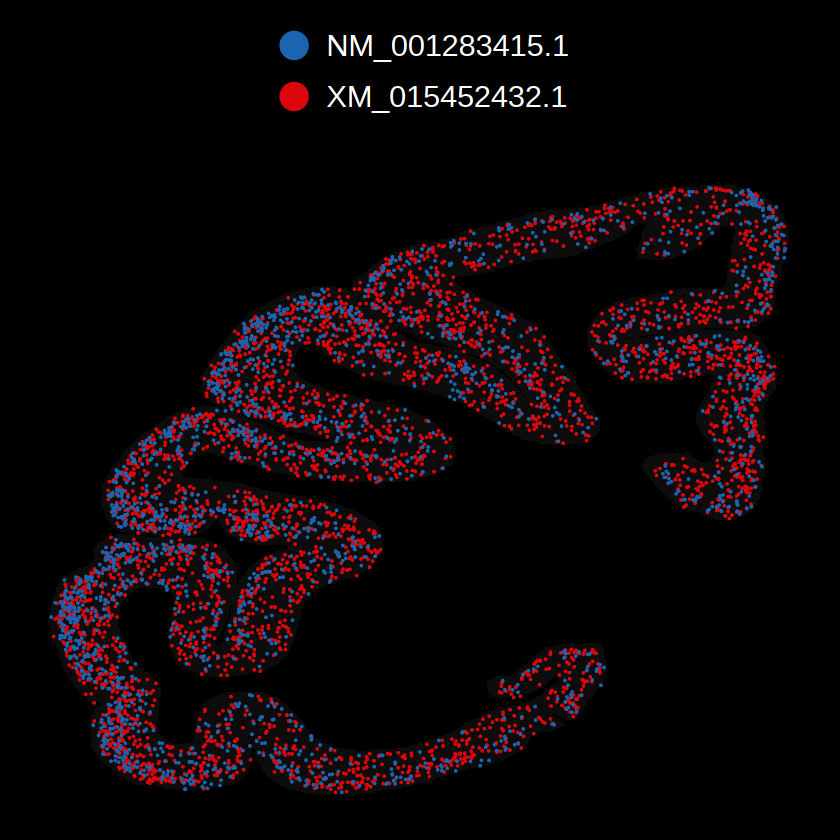

In [49]:
geneex = "ARPP19"
transid = c("XM_015452432.1","NM_001283415.1")
fsraw.hub = readtransf.df[readtransf.df$layer %in% paste0("l",1:6) & readtransf.df$gene_id %in% geneex,]
fsraw.hub = fsraw.hub %>% group_by(readid) %>% filter(transcript_id == "NM_001283415.1" | sum(transcript_id %in% "NM_001283415.1") == 0)
pc2 = SpCasePlot(fsraw.hub,geneex,transid,backpt[backpt$layer %in% paste0("l",1:6),],0.7)
pc2 = pc2 + scale_x_reverse() + scale_y_reverse()
pc2
fileid = paste0("downstream_analysis/result/figure_revision/T42_",geneex,"_layer_case_bin1_25_11_24.pdf")
ggexport(pc2,filename = fileid,width = 4,height = 6)

In [23]:
isosigi = isosigls$region
#isosigi[isosigi$count > 200 & abs(isosigi$dr) > 0.15,]
#isosigi = isosigls$region
isosigi[isosigi$gene_id == "RTN1",]

,gene_id,transcript_id,areatr,count,genecount,relative,meanrelative,otherrelative,dr,sig,pvalue,padj
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
30821,RTN1,XM_005561388.2,1/2,40,628,0.06369427,0.05583274,0.05554157,0.0081526937,N,0.0007616735,0.002157813
30822,RTN1,XM_005561388.2,23a,6,82,0.07317073,0.05583274,0.05519059,0.0179801381,N,0.0007616735,0.002157813
30823,RTN1,XM_005561388.2,23b,10,98,0.10204082,0.05583274,0.05412133,0.0479194851,N,0.0007616735,0.002157813
30824,RTN1,XM_005561388.2,23c,12,172,0.06976744,0.05583274,0.05531664,0.0144508005,N,0.0007616735,0.002157813
30825,RTN1,XM_005561388.2,30,8,74,0.10810811,0.05583274,0.05389662,0.0542114914,N,0.0007616735,0.002157813
30826,RTN1,XM_005561388.2,31,2,90,0.02222222,0.05583274,0.05707758,-0.0348553532,N,0.0007616735,0.002157813
30827,RTN1,XM_005561388.2,3a/b,4,238,0.01680672,0.05583274,0.05727815,-0.0404714268,N,0.0007616735,0.002157813
30828,RTN1,XM_005561388.2,7op,24,352,0.06818182,0.05583274,0.05537537,0.0128064500,N,0.0007616735,0.002157813
30829,RTN1,XM_005561388.2,AI,6,108,0.05555556,0.05583274,0.05584301,-0.0002874520,N,0.0007616735,0.002157813


In [24]:
fsraw.hub = readtransf.df[readtransf.df$layer %in% paste0("l",1:6) & readtransf.df$gene_id %in% geneex,]
fsraw.hub = fsraw.hub %>% group_by(readid) %>% filter(length(unique(transcript_id)) == 1)
length(unique(fsraw.hub$transcript_id))

[1] 3

In [32]:
unique(fsraw.hub$transcript_id)
unique(fsraw.hub$transcript_id)

[1] "XM_005561389.2" "XM_005561388.2"

[1] "XM_005561388.2" "XM_005561389.2"

In [34]:
unique(fsraw.hub$region)

[1] "3a/b" "23b"  "23c"  "1/2"  "30"   "29"   "V3v"  "V2"   "VIP"  "PEa" 
[11] "PE"   "LIPv" "TFO"  "CM"   "LIPd" "7op"  "PGa"  "AI"   "PG"   "FST" 
[21] "TEpv" "TPO"  "CL"   "TEO"  "TEa"  "TAa"  "CPB"  "TEpd" "31"   "23a"

Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
file saved to downstream_analysis/result/figure_revision/T42_RTN1_layer_case_bin1_25_11_24.pdf



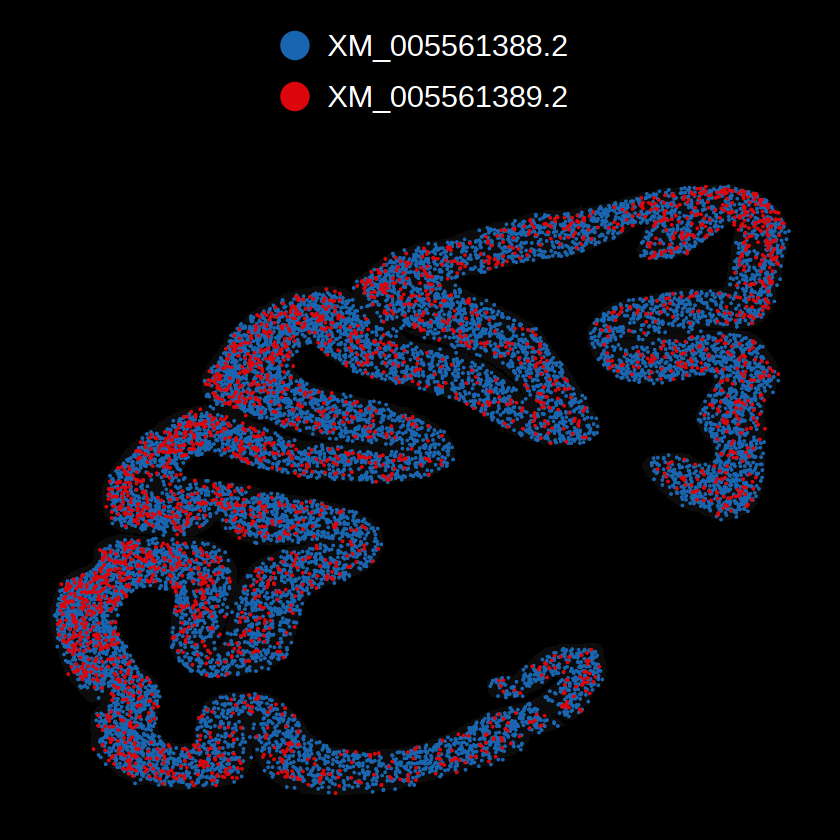

In [52]:
geneex = "RTN1"
transid = c("XM_005561388.2","XM_005561389.2")
fsraw.hub = readtransf.df[readtransf.df$layer %in% paste0("l",1:6) & readtransf.df$gene_id %in% geneex,]
fsraw.hub = fsraw.hub %>% group_by(readid) %>% filter(transcript_id == "XM_005561388.2" | sum(transcript_id %in% "XM_005561388.2") == 0)
pc2 = SpCasePlot(fsraw.hub,geneex,transid,backpt[backpt$layer %in% paste0("l",1:6),],0.7)
pc2 = pc2 + scale_x_reverse() + scale_y_reverse()
pc2
fileid = paste0("downstream_analysis/result/figure_revision/T42_",geneex,"_layer_case_bin1_25_11_24.pdf")
ggexport(pc2,filename = fileid,width = 4,height = 6)

Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."


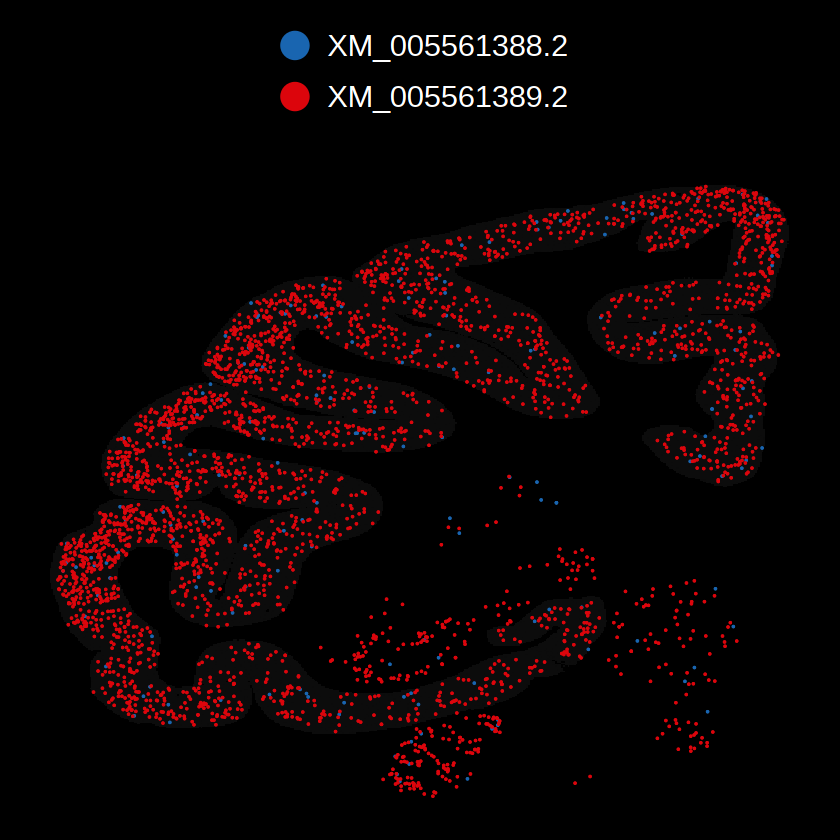

In [22]:
pc2